In [1]:
import numpy as np
import pandas as pd
from sklearn.base import clone 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression
import matplotlib.pyplot as plt
import time
import json
import sys
import os
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src.utils import CrossValidation
from src.feature_selection import UnsupervisedFeatureSelection as unsup_fs
from src.feature_selection import IntrinsicFeatureSelection as ifs
from src.plotting import plot_pairwise_correlations
from src.feature_selection import SequentialFeatureSelection


# Load in the data

In [2]:
proc = GatherFeatureDatasets(is_p=True)

In [3]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
all_train_df = pd.read_csv(f'{data_dir}/p.train.csv')

In [4]:
# Use station YUF for experimenting with models because it has 1433 training examples, 
# which is ~half as much as YNR, so training should go faster. But should still be enough 
# examples for training good models. It is also one of the stations with a 
# UUSS correction, so already used for magnitude calculations and amplitudes should be good quality. 
stat = "YUF"
station_feature_dict, station_meta_dict, feature_names = proc.process_station_datasets(stat, 
                                                                                        all_train_df,
                                                                                        scaler=False,
                                                                                        linear_model=False,
                                                                                        source_dist_type='dist')

YUF
X shape: (1433, 45), y shape: (1433,)


In [5]:
feature_names

array(['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_4',
       'amp_ratio_5', 'amp_ratio_6', 'amp_ratio_7', 'amp_ratio_8',
       'amp_ratio_9', 'amp_ratio_10', 'amp_ratio_11', 'amp_ratio_12',
       'amp_ratio_13', 'amp_ratio_14', 'amp_ratio_15', 'amp_ratio_16',
       'amp_ratio_17', 'amp_ratio_18', 'amp_1', 'amp_2', 'amp_3', 'amp_4',
       'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11',
       'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17',
       'amp_18', 'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_depth_km',
       'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg'], dtype='<U32')

In [6]:
### Set Parameters ###
cv_random_state=2652124
# The model to used to estimate feature importance 
estimator_model =  DecisionTreeRegressor()
# Boolean - True if data for estimator_model needs to be scaled
estimator_scaler = False
# The main model to fit
predictor_model = SVR(kernel='rbf')
# Boolean - True if data for model needs to be scaled 
model_scaler = True
# The scoring method to use in RFECV and GridCV
scoring_method = 'r2'
# The function used to evaluate the performance on the test model
score_func = r2_score
# True if a larger score_func value is better
larger_score_is_better = True
# The parameter space for GridCV to search
# Decrease upper-limit of C for linear model because 100 is very slow 
svr_Cspace = [1, 10, 100]
svr_gspace = [0.1, 0.01, 0.001]
param_grid = [
    {'m__C': svr_Cspace, 'm__gamma': svr_gspace},
]
# The number of jobs for RFECV and GridCV to use
n_jobs = 10
# number of folds for outer CV
cv_folds_outer = 10
# number of times to repeat outer CV
n_outer_repeats = 1
# number of folds for inner CV (used for hyperparameter tuning)
cv_folds_inner = 5
# number of folds for the final hyperparameter grid search
cv_folds_hp = 10
# Run grid search over all features
run_gridsearchcv_all = True

### Intrisic feature selection information 
# Function that takes in X, y, list of np arrays containing 
# the indices of features to filter, and K features to select
if_feat_inds = [np.arange(0, 18), np.arange(18, 36)]
if_K = 5
#####################

In [7]:
X = station_feature_dict['X_train']
y = station_meta_dict['y_train']

# Reduce correlated features

In [8]:
hp_grid_search, hp_cv = CrossValidation.setup_cv(predictor_model, 
                                                param_grid, 
                                                model_scaler=model_scaler, 
                                                scoring_method=scoring_method, 
                                                n_jobs=n_jobs, 
                                                cv_folds=cv_folds_outer, 
                                                cv_random_state=cv_random_state, 
                                                refit_model=False)

In [9]:
kept_features = unsup_fs.remove_highly_correlated_features(X, thresh=0.75)

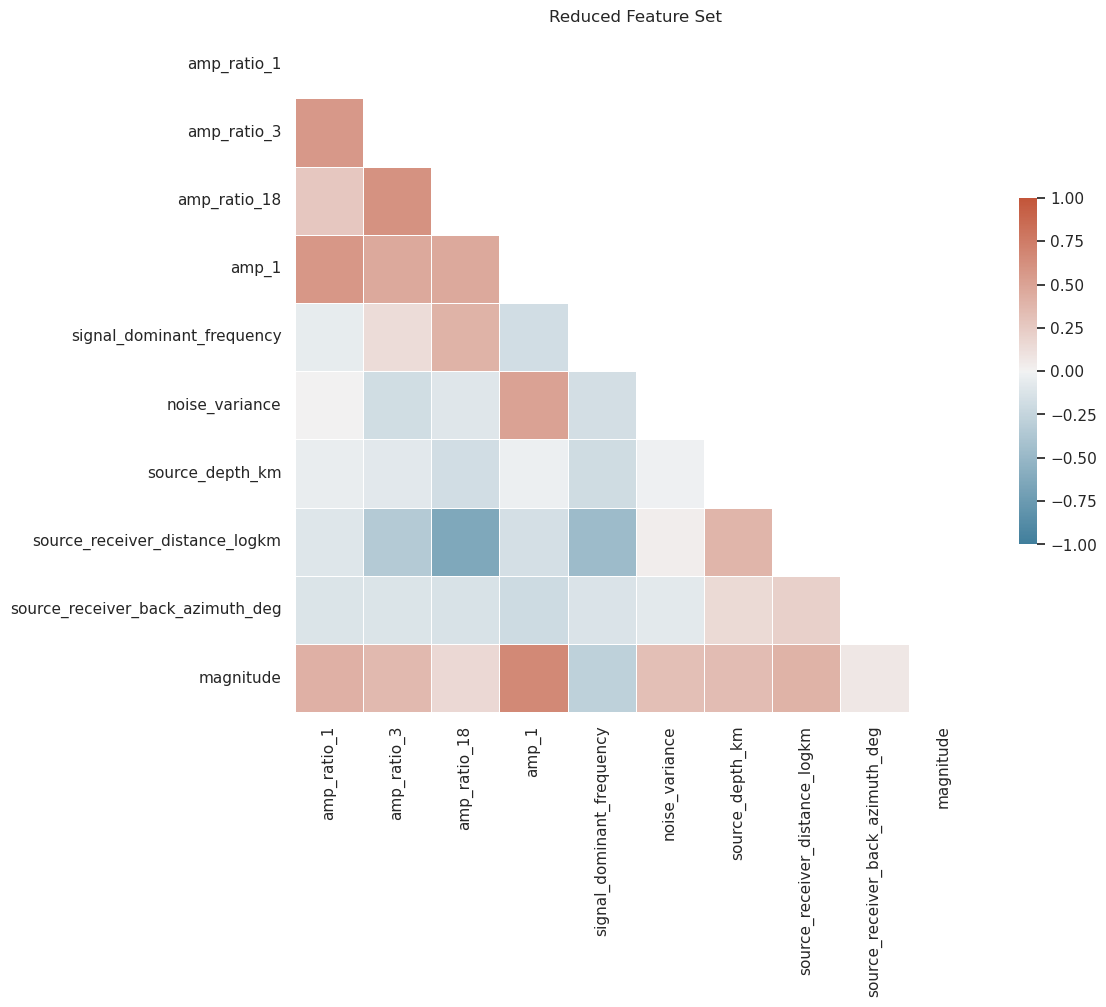

In [10]:
kept_feature_names = feature_names[kept_features]
plot_pairwise_correlations(X[:, kept_features], y, kept_feature_names, "Reduced Feature Set",
                           xticklabels=1)

In [11]:
corr_gs_results, _ = CrossValidation.do_gridsearchcv(hp_grid_search,
                                X[:, kept_features],
                                y,
                                None)

In [12]:
CrossValidation.get_gridsearchcv_best_results(corr_gs_results)

(0.8745364314697618, 0.04293839702976155, {'m__C': 100, 'm__gamma': 0.01})

# Sequential Feature Selection

In [13]:
inner_grid_search, cv_inner = CrossValidation.setup_cv(predictor_model, 
                                                                param_grid, 
                                                                model_scaler=model_scaler, 
                                                                scoring_method=scoring_method, 
                                                                n_jobs=n_jobs, 
                                                                cv_folds=cv_folds_inner, 
                                                                cv_random_state=cv_random_state, 
                                                                refit_model=True)

# Approach more similar to RFECV
Go through all features for all folds. Average the test scores across folds to find N with the best performance. Can use N later to select features or filter results down to add CI to features selected from the entire training set using tol or something. Could also look at most frequently selected early features across folds (apply tol retroactively).

In [16]:
np.arange(X.shape[1])[kept_features]

array([ 0,  2, 17, 18, 36, 41, 42, 43, 44])

In [17]:
SequentialFeatureSelection.do_forward_selection(X[:100, :],
                                                y[:100],
                                                X[100:110, :],
                                                y[100:110],
                                                inner_grid_search,
                                                np.arange(X.shape[1])[~kept_features][0:5], 
                                                score_func,
                                                early_stopping_tol=-0.05,
                                                required_feature_ids=np.arange(X.shape[1])[kept_features])

[0, 2, 17, 18, 36, 41, 42, 43, 44]
[ 0  2 17 18 36 41 42 43 44  1]
[ 0  2 17 18 36 41 42 43 44  3]
[ 0  2 17 18 36 41 42 43 44  4]
[ 0  2 17 18 36 41 42 43 44  5]
[ 0  2 17 18 36 41 42 43 44  6]
[ 0  2 17 18 36 41 42 43 44  5  1]
[ 0  2 17 18 36 41 42 43 44  5  3]
[ 0  2 17 18 36 41 42 43 44  5  4]
[ 0  2 17 18 36 41 42 43 44  5  6]
[ 0  2 17 18 36 41 42 43 44  5  6  1]
[ 0  2 17 18 36 41 42 43 44  5  6  3]
[ 0  2 17 18 36 41 42 43 44  5  6  4]
[ 0  2 17 18 36 41 42 43 44  5  6  1  3]
[ 0  2 17 18 36 41 42 43 44  5  6  1  4]
Stopping early


([0, 2, 17, 18, 36, 41, 42, 43, 44, 5, 6, 1, 3],
 [0.8483284073752726,
  0.894497094121057,
  0.8841981253604584,
  0.8595541152072521,
  0.8197885493917314],
 array([[0.83184043, 0.81060912, 0.85002962, 0.89449709, 0.88274229],
        [0.87592973, 0.85370199, 0.82583676,        nan, 0.88419813],
        [0.85955412, 0.84657167, 0.79551033,        nan,        nan],
        [       nan, 0.81978855, 0.76810868,        nan,        nan]]))

In [18]:
N_feature_to_use, results = SequentialFeatureSelection.sequential_cv_N(X[:100, :],
                                         y[:100],
                                        predictor_model,
                                        param_grid,
                                        np.arange(X.shape[1])[~kept_features][0:5],
                                        required_feature_ids=None,
                                        predictor_scaler=model_scaler,
                                        scoring_method=scoring_method,
                                        score_func=score_func,
                                        n_jobs=n_jobs,
                                        cv_folds_outer=2,
                                        cv_folds_inner=cv_folds_inner,
                                        n_outer_repeats=1,
                                        cv_random_state=cv_random_state,
                                        larger_score_is_better=larger_score_is_better,
                                        )
results

[3 1]
[3 4]
[3 5]
[3 6]
[3 4 1]
[3 4 5]
[3 4 6]
[3 4 1 5]
[3 4 1 6]
[3 4 1 5 6]
Fold 0: N=1, test_score=0.435
[3 1]
[3 4]
[3 5]
[3 6]
[3 6 1]
[3 6 4]
[3 6 5]
[3 6 5 1]
[3 6 5 4]
[3 6 5 4 1]
Fold 1: N=2, test_score=0.253
total time: 2.29 s
Selected number of features: 1 (avg. score of 0.34)


{'N_scores': array([[0.        , 0.4345974 , 0.17392918, 0.23905042, 0.28205414,
         0.31708179],
        [0.        , 0.23560904, 0.2531576 , 0.24756776, 0.22109412,
         0.14733788]]),
 'selected_feats': array([[3, 4, 1, 5, 6],
        [3, 6, 5, 4, 1]]),
 'intrinsic_K_feature_selection': None}

In [19]:
N_feature_to_use, results = SequentialFeatureSelection.sequential_cv_N(X[:100, :],
                                         y[:100],
                                        predictor_model,
                                        param_grid,
                                        np.arange(X.shape[1])[~kept_features][0:5],
                                        required_feature_ids=np.arange(X.shape[1])[kept_features],
                                        predictor_scaler=model_scaler,
                                        scoring_method=scoring_method,
                                        score_func=score_func,
                                        n_jobs=n_jobs,
                                        cv_folds_outer=2,
                                        cv_folds_inner=cv_folds_inner,
                                        n_outer_repeats=1,
                                        cv_random_state=cv_random_state,
                                        larger_score_is_better=larger_score_is_better,
                                        intrinsic_filter_func=None,
                                        feature_inds_to_filter=None,
                                        intrinsic_filter_K=5
                                        )
results

[0, 2, 17, 18, 36, 41, 42, 43, 44]
[ 0  2 17 18 36 41 42 43 44  1]
[ 0  2 17 18 36 41 42 43 44  3]
[ 0  2 17 18 36 41 42 43 44  4]
[ 0  2 17 18 36 41 42 43 44  5]
[ 0  2 17 18 36 41 42 43 44  6]
[ 0  2 17 18 36 41 42 43 44  4  1]
[ 0  2 17 18 36 41 42 43 44  4  3]
[ 0  2 17 18 36 41 42 43 44  4  5]
[ 0  2 17 18 36 41 42 43 44  4  6]
[ 0  2 17 18 36 41 42 43 44  4  3  1]
[ 0  2 17 18 36 41 42 43 44  4  3  5]
[ 0  2 17 18 36 41 42 43 44  4  3  6]
[ 0  2 17 18 36 41 42 43 44  4  3  6  1]
[ 0  2 17 18 36 41 42 43 44  4  3  6  5]
[ 0  2 17 18 36 41 42 43 44  4  3  6  5  1]
Fold 0: N=1, test_score=0.826
[0, 2, 17, 18, 36, 41, 42, 43, 44]
[ 0  2 17 18 36 41 42 43 44  1]
[ 0  2 17 18 36 41 42 43 44  3]
[ 0  2 17 18 36 41 42 43 44  4]
[ 0  2 17 18 36 41 42 43 44  5]
[ 0  2 17 18 36 41 42 43 44  6]
[ 0  2 17 18 36 41 42 43 44  3  1]
[ 0  2 17 18 36 41 42 43 44  3  4]
[ 0  2 17 18 36 41 42 43 44  3  5]
[ 0  2 17 18 36 41 42 43 44  3  6]
[ 0  2 17 18 36 41 42 43 44  3  1  4]
[ 0  2 17 18 36 41 42 

{'N_scores': array([[0.80385205, 0.8256849 , 0.82291943, 0.81184804, 0.80500664,
         0.7558027 ],
        [0.83993835, 0.85830005, 0.85208002, 0.84141311, 0.8373089 ,
         0.84018034]]),
 'selected_feats': array([[4, 3, 6, 5, 1],
        [3, 1, 5, 4, 6]]),
 'intrinsic_K_feature_selection': None}

In [25]:
N_feature_to_use, results = SequentialFeatureSelection.sequential_cv_N(X[:100, :],
                                         y[:100],
                                        predictor_model,
                                        param_grid,
                                        np.arange(X.shape[1])[~kept_features][0:5],
                                        required_feature_ids=np.arange(X.shape[1])[kept_features],
                                        predictor_scaler=model_scaler,
                                        scoring_method=scoring_method,
                                        score_func=score_func,
                                        n_jobs=n_jobs,
                                        cv_folds_outer=2,
                                        cv_folds_inner=cv_folds_inner,
                                        n_outer_repeats=1,
                                        cv_random_state=cv_random_state,
                                        larger_score_is_better=larger_score_is_better,
                                        intrinsic_filter_func=ifs.MI_filter_func,
                                        feature_inds_to_filter=[np.arange(X.shape[1])[~kept_features][0:4]],
                                        intrinsic_filter_K=2
                                        )

Starting features to select from [1 3 4 5 6]
reducing features to [3 4 6]
[0, 2, 17, 18, 36, 41, 42, 43, 44]
[ 0  2 17 18 36 41 42 43 44  3]
[ 0  2 17 18 36 41 42 43 44  4]
[ 0  2 17 18 36 41 42 43 44  6]
[ 0  2 17 18 36 41 42 43 44  4  3]
[ 0  2 17 18 36 41 42 43 44  4  6]
[ 0  2 17 18 36 41 42 43 44  4  3  6]
Fold 0: N=1, test_score=0.826
Starting features to select from [3 4 6]
reducing features to [3 4 6]
[0, 2, 17, 18, 36, 41, 42, 43, 44]
[ 0  2 17 18 36 41 42 43 44  3]
[ 0  2 17 18 36 41 42 43 44  4]
[ 0  2 17 18 36 41 42 43 44  6]
[ 0  2 17 18 36 41 42 43 44  3  4]
[ 0  2 17 18 36 41 42 43 44  3  6]
[ 0  2 17 18 36 41 42 43 44  3  4  6]
Fold 1: N=1, test_score=0.858
total time: 1.02 s
Selected number of features: 1 (avg. score of 0.84)


# Alternate sequential approach (better?)
Instead of performing sequential feature selection for each fold entirely independently, train a model for each fold with the potential feature, average the test scores, and select the feature with the best average test score to move forward with. 

In [14]:
cv_outer = RepeatedKFold(n_splits=cv_folds_outer, 
                            n_repeats=n_outer_repeats, 
                            random_state=cv_random_state)

In [15]:
ids, ids_scores, all_scores = SequentialFeatureSelection.do_forward_selection_cv(X[:100, :],
                                                    y[:100],
                                                    np.arange(X.shape[1])[kept_features], 
                                                    cv_outer,
                                                    inner_grid_search,
                                                    scoring_method,
                                                    larger_score_is_better=larger_score_is_better,
                                                    required_feature_ids=None,
                                                    verbose=True)

0 0.07878296223960755
2 0.12840377048173526
17 -0.019360371418905408
18 0.45241198084531675
36 -0.0273893301776578
41 -0.012552705912197681
42 -0.10898232926837163
43 -0.016960446239767467
44 -0.14491124357687704
[18  0] 0.43480202489038666
[18  2] 0.28159068174693846
[18 17] 0.5733733674387368
[18 36] 0.5461633659834609
[18 41] 0.49304014183711703
[18 42] 0.6020293651519184
[18 43] 0.7192698073814443
[18 44] 0.530508686559904
[18 43  0] 0.7251174319476397
[18 43  2] 0.7271467014871911
[18 43 17] 0.7816858659034802
[18 43 36] 0.7424891857201514
[18 43 41] 0.6744328337641344
[18 43 42] 0.739397063466181
[18 43 44] 0.7486444532892756
[18 43 17  0] 0.7646548474096275
[18 43 17  2] 0.7643867534572459
[18 43 17 36] 0.7398910509519994
[18 43 17 41] 0.796508055431459
[18 43 17 42] 0.8104446648163126
[18 43 17 44] 0.7534868981392808
[18 43 17 42  0] 0.7947362807029116
[18 43 17 42  2] 0.8089177311743099
[18 43 17 42 36] 0.8055419057984562
[18 43 17 42 41] 0.8228868030168195
[18 43 17 42 44] 0.

In [17]:
ids, ids_scores, all_scores = SequentialFeatureSelection.do_forward_selection_cv(X[:100, :],
                                                                                y[:100],
                                                                                np.arange(X.shape[1])[~kept_features], 
                                                                                cv_outer,
                                                                                inner_grid_search,
                                                                                scoring_method,
                                                                                larger_score_is_better=larger_score_is_better,
                                                                                required_feature_ids=np.arange(X.shape[1])[kept_features],
                                                                                verbose=True,
                                                                                early_stopping_tol=0.005)

[0, 2, 17, 18, 36, 41, 42, 43, 44]
[ 0  2 17 18 36 41 42 43 44  1] 0.8271620670211977
[ 0  2 17 18 36 41 42 43 44  3] 0.8314736729232539
[ 0  2 17 18 36 41 42 43 44  4] 0.8073976948355828
[ 0  2 17 18 36 41 42 43 44  5] 0.830719438469224
[ 0  2 17 18 36 41 42 43 44  6] 0.8281797489995905
[ 0  2 17 18 36 41 42 43 44  7] 0.8280685035448873
[ 0  2 17 18 36 41 42 43 44  8] 0.8324062683932898
[ 0  2 17 18 36 41 42 43 44  9] 0.8344112671702149
[ 0  2 17 18 36 41 42 43 44 10] 0.8359416488368488
[ 0  2 17 18 36 41 42 43 44 11] 0.8392321689062736
[ 0  2 17 18 36 41 42 43 44 12] 0.8349800850077138
[ 0  2 17 18 36 41 42 43 44 13] 0.8387006683399552
[ 0  2 17 18 36 41 42 43 44 14] 0.8375869012869996
[ 0  2 17 18 36 41 42 43 44 15] 0.8382667980791517
[ 0  2 17 18 36 41 42 43 44 16] 0.8382138722030034
[ 0  2 17 18 36 41 42 43 44 19] 0.8641252318921679
[ 0  2 17 18 36 41 42 43 44 20] 0.8653599548755171
[ 0  2 17 18 36 41 42 43 44 21] 0.8614671634256043
[ 0  2 17 18 36 41 42 43 44 22] 0.85475171552083

In [20]:
ids

[0, 2, 17, 18, 36, 41, 42, 43, 44, 20, 23, 5]

In [21]:
ids_scores

array([[0.84353695, 0.74259257, 0.92787583],
       [0.86535995, 0.76951245, 0.97562155],
       [0.87080124, 0.76684915, 0.97382038],
       [0.87297905, 0.77265627, 0.97134499]])